<a href="https://colab.research.google.com/github/NaydelinAidee/Investigaci-n-de-Operaciones-Nay/blob/main/PertCPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Qué es el Método de la Ruta Crítica (CPM)?
El Método de la Ruta Crítica (CPM) es una técnica esencial en la Investigación de Operaciones y la Gestión de Proyectos utilizada para modelar, programar y controlar proyectos complejos.

Su objetivo principal es determinar la secuencia más larga de actividades dentro de un proyecto. Esta secuencia es la Ruta Crítica, y su duración define el tiempo mínimo total en el que se puede completar el proyecto.

Conceptos Clave

**Actividad:** Una tarea específica que requiere tiempo y recursos.

**Duración:** El tiempo estimado necesario para completar una actividad.

**Predecesoras:** Actividades que deben completarse antes de que otra actividad pueda comenzar (dependencias).

**Ruta Crítica:** La cadena de actividades donde cualquier retraso en una de ellas retrasa, automáticamente, el proyecto entero.

**Holgura (Slack/Float):** El tiempo máximo que una actividad puede retrasarse sin afectar la fecha de finalización del proyecto. Las actividades en la Ruta Crítica tienen una holgura igual a cero.


Para aplicar el CPM, el proyecto **se modela como un Grafo Dirigido Acíclico** (DAG), que es donde entra la librería networkx.

**Nodos (Vértices):** Representan las actividades del proyecto (o los eventos de inicio/fin de esas actividades, dependiendo del enfoque).

**Aristas (Lados): **Representan las dependencias entre actividades (la flecha indica la dirección del flujo de trabajo, ej.: A→B significa que A debe terminar antes de que B pueda empezar).

**Peso de las Aristas:** Generalmente, se asocia el peso a la duración de la actividad que está terminando en ese nodo o a la arista misma.


# Los Cuatro Tiempos Fundamentales (Cálculos de CPM)
El corazón del CPM es el cálculo de cuatro tiempos para cada actividad:

**Tiempo de Inicio Temprano (TIE):** El momento más pronto en el que una actividad puede comenzar. Se calcula yendo hacia adelante en el grafo (desde el INICIO).

**Tiempo de Finalización Temprana (TFE):** El momento más pronto en el que una actividad puede terminar. (TFE=TIE+Duración).

**Tiempo de Finalización Tardía (TFT):** El momento más tarde en el que una actividad puede terminar sin retrasar el proyecto. Se calcula yendo hacia atrás en el grafo (desde el FIN ).

**Tiempo de Inicio Tardío (TIT):** El momento más tarde en el que una actividad puede comenzar sin retrasar el proyecto. (TIT=TFT−Duración).

**Determinación de la Ruta Crítica**

Una vez que tienes los cuatro tiempos:

Holgura=TFT−TFE=TIT−TIE
Si Holgura> 0: La actividad tiene margen para retrasarse.

Si Holgura = 0: La actividad es crítica y forma parte de la Ruta Crítica.

Veamoslo con un ejemplo para análizar de una mejor forma:


  Queremos simular la cadena de suministro de Coca-Cola, adaptando su desafío logístico a un modelo de gestión de proyectos. El **objetivo es determinar el tiempo mínimo requerido para que un lote de productos sea fabricado y entregado desde las fábricas del norte (Baja California y Chihuahua) hasta los clientes mayoristas en Ciudad de México.**




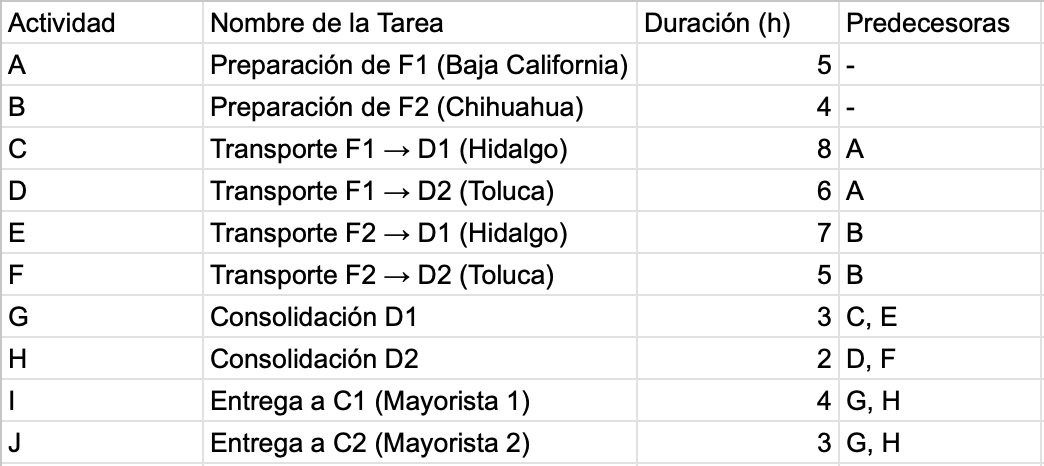

Hemos definido 10 actividades (A a J), cada una con una duración estimada en horas, y sus respectivas predecesoras o dependencias. Por ejemplo, la consolidación en el Distribuidor 1 (Actividad G) solo puede comenzar cuando los transportes de F1 y F2 (Actividades C y E) han finalizado."

importamos nuestras librerias

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

PASO 1: DEFINICIÓN DEL PROYECTO

In [ ]:
# Duración de las actividades en horas y sus predecesoras
actividades = {
    'A': {'duracion': 5, 'predecesoras': []},       # Preparación F1
    'B': {'duracion': 4, 'predecesoras': []},       # Preparación F2
    'C': {'duracion': 8, 'predecesoras': ['A']},    # Transporte F1 -> D1
    'D': {'duracion': 6, 'predecesoras': ['A']},    # Transporte F1 -> D2
    'E': {'duracion': 7, 'predecesoras': ['B']},    # Transporte F2 -> D1
    'F': {'duracion': 5, 'predecesoras': ['B']},    # Transporte F2 -> D2
    'G': {'duracion': 3, 'predecesoras': ['C', 'E']},# Consolidación D1
    'H': {'duracion': 2, 'predecesoras': ['D', 'F']},# Consolidación D2
    'I': {'duracion': 4, 'predecesoras': ['G', 'H']},# Entrega a C1
    'J': {'duracion': 3, 'predecesoras': ['G', 'H']} # Entrega a C2
}


PASO 2: CONSTRUCCIÓN DEL GRAFO DIRIGIDO (DAG)

In [ ]:
G = nx.DiGraph()

# 2a. Agregar nodos y aristas basadas en dependencias
for actividad, datos in actividades.items():
    G.add_node(actividad, duracion=datos['duracion'])
    for predecesora in datos['predecesoras']:
        G.add_edge(predecesora, actividad)

# 2b. Agregar nodos ficticios de INICIO y FIN (duración 0)
G.add_node('INICIO', duracion=0)
G.add_node('FIN', duracion=0)

# Conectar INICIO a actividades sin predecesoras ('A' y 'B')
for actividad, datos in actividades.items():
    if not datos['predecesoras']:
        G.add_edge('INICIO', actividad)

# Conectar actividades finales a FIN ('I' y 'J') - Lógica robusta
actividades_intermedias = set(actividades.keys())

for nodo in actividades_intermedias:
    # Si la lista de sucesores del nodo está vacía, es un nodo final.
    if not list(G.successors(nodo)):
        G.add_edge(nodo, 'FIN')

print(f"Grafo construido con {G.number_of_nodes()} nodos (incluyendo INICIO/FIN).")

PASO 3: CÁLCULO HACIA ADELANTE (TIE y TFE)

In [ ]:
print("--- 2. CÁLCULO HACIA ADELANTE ---")
for node in G.nodes():
    G.nodes[node]['TIE'] = 0

orden_topologico = list(nx.topological_sort(G))

for node in orden_topologico:
    duracion = G.nodes[node].get('duracion', 0)
    G.nodes[node]['TFE'] = G.nodes[node]['TIE'] + duracion

    # Propagar TFE a los sucesores (TIE es el MÁXIMO TFE del predecesor)
    for successor in G.successors(node):
        TFE_predecesor = G.nodes[node]['TFE']
        G.nodes[successor]['TIE'] = max(G.nodes[successor]['TIE'], TFE_predecesor)

duracion_total = G.nodes['FIN']['TIE']
print(f"Duración Total del Proyecto (TFE de FIN): {duracion_total} horas.")



PASO 4: CÁLCULO HACIA ATRÁS (TIT, TFT y Holgura)

In [ ]:
print("--- 3. CÁLCULO HACIA ATRÁS Y HOLGURA ---")
# Inicializar TFT con la Duración Total
for node in G.nodes():
    G.nodes[node]['TFT'] = duracion_total

orden_topologico_inverso = list(reversed(orden_topologico))

ruta_critica_nodos = []
datos_proyecto = []

for node in orden_topologico_inverso:
    duracion = G.nodes[node].get('duracion', 0)
    G.nodes[node]['TIT'] = G.nodes[node]['TFT'] - duracion

    # Propagar TIT a las predecesoras (TFT es el MÍNIMO TIT del sucesor)
    for predecessor in G.predecessors(node):
        TIT_sucesor = G.nodes[node]['TIT']
        G.nodes[predecessor]['TFT'] = min(G.nodes[predecessor]['TFT'], TIT_sucesor)

    # Calcular Holgura y clasificar
    holgura = G.nodes[node]['TFT'] - G.nodes[node]['TFE']
    es_critica = (holgura == 0)

    G.nodes[node]['Holgura'] = holgura
    G.nodes[node]['Crítica'] = es_critica

    if es_critica and node not in ['INICIO', 'FIN']:
        ruta_critica_nodos.append(node)

    datos_proyecto.append({
        'Actividad': node,
        'Duración': G.nodes[node].get('duracion', 0),
        'TIE': G.nodes[node]['TIE'],
        'TFE': G.nodes[node]['TFE'],
        'TIT': G.nodes[node]['TIT'],
        'TFT': G.nodes[node]['TFT'],
        'Holgura': holgura,
        'Crítica': es_critica
    })

PASO 5: PRESENTACIÓN DE RESULTADOS

In [ ]:
df_resultados = pd.DataFrame(datos_proyecto)
# Ordenar por TIE para una mejor lectura cronológica
df_presentacion = df_resultados.sort_values(by='TIE')

print("\n--- 4. TABLA DE RESULTADOS DEL ANÁLISIS CPM ---")
print("TIE: Inicio Temprano, TFE: Finalización Temprana, TIT: Inicio Tardío, TFT: Finalización Tardía")
print(df_presentacion.to_markdown(index=False))

print(f"\nLa Ruta Crítica (secuencia de Holgura 0) es: {' -> '.join(ruta_critica_nodos)}")
print(f"Duración Mínima del Proyecto: {duracion_total} horas.")

PASO 6: VISUALIZACIÓN DEL GRAFO Y LA RUTA CRÍTICA

In [ ]:
print("\n--- 5. VISUALIZACIÓN ---")

# 1. Preparar estilos
pos = nx.spring_layout(G, seed=42)
node_colors = ['red' if G.nodes[n].get('Crítica') else 'skyblue' for n in G.nodes()]

# Identificar aristas críticas
critical_path_set = set()
for i in range(len(ruta_critica_nodos) - 1):
    critical_path_set.add((ruta_critica_nodos[i], ruta_critica_nodos[i+1]))

if ruta_critica_nodos:
    critical_path_set.add(('INICIO', ruta_critica_nodos[0]))
    critical_path_set.add((ruta_critica_nodos[-1], 'FIN'))

edge_colors = ['red' if (u, v) in critical_path_set else 'gray' for u, v in G.edges()]

# Etiquetas para mostrar la actividad y su duración
node_labels = {
    node: f'{node}\n(D={G.nodes[node].get("duracion", 0)}h)'
    for node in G.nodes()
}

# 2. Dibujar y mostrar el grafo
plt.figure(figsize=(14, 9))
nx.draw(
    G, pos,
    with_labels=False,
    node_size=3500,
    node_color=node_colors,
    edge_color=edge_colors,
    width=2,
    arrowstyle='->',
    arrowsize=25
)

# Dibujar las etiquetas de los nodos
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')

plt.title(f"Ruta Crítica del Proyecto Logístico - Duración Total: {duracion_total} horas", fontsize=16)
plt.show()

Ahora veamoslo completo:

--- 1. DEFINICIÓN DEL PROYECTO ---
Grafo construido con 12 nodos (incluyendo INICIO/FIN).
--- 2. CÁLCULO HACIA ADELANTE ---
Duración Total del Proyecto (TFE de FIN): 20 horas.
--- 3. CÁLCULO HACIA ATRÁS Y HOLGURA ---

--- 4. TABLA DE RESULTADOS DEL ANÁLISIS CPM ---
TIE: Inicio Temprano, TFE: Finalización Temprana, TIT: Inicio Tardío, TFT: Finalización Tardía
| Actividad   |   Duración |   TIE |   TFE |   TIT |   TFT |   Holgura | Crítica   |
|:------------|-----------:|------:|------:|------:|------:|----------:|:----------|
| A           |          5 |     0 |     5 |     0 |     5 |         0 | True      |
| INICIO      |          0 |     0 |     0 |     0 |     0 |         0 | True      |
| B           |          4 |     0 |     4 |     2 |     6 |         2 | False     |
| E           |          7 |     4 |    11 |     6 |    13 |         2 | False     |
| F           |          5 |     4 |     9 |     9 |    14 |         5 | False     |
| C           |          8 |     5 |    13 |

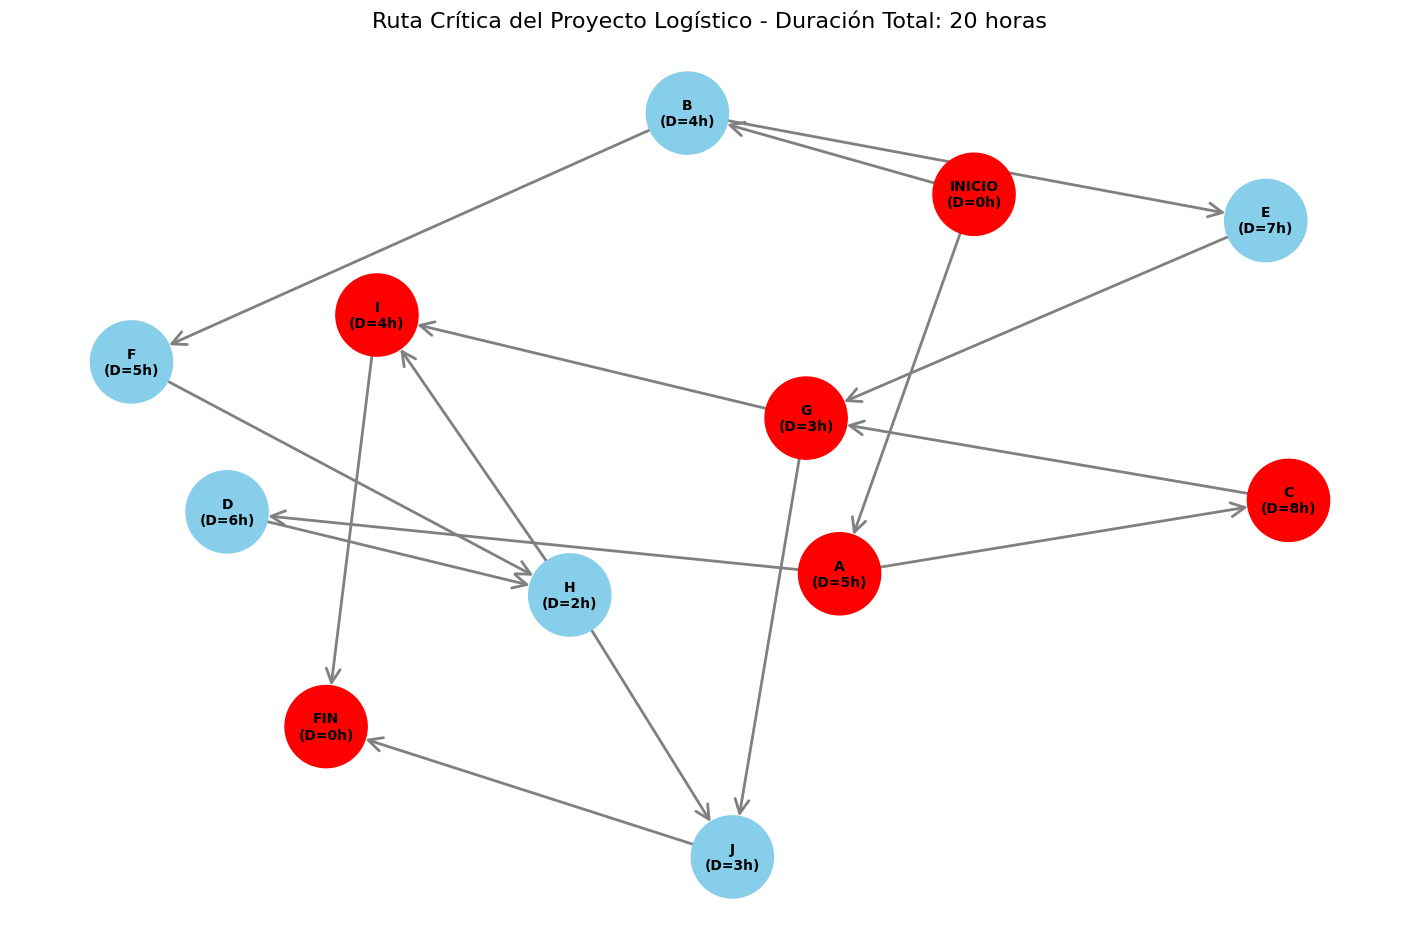

In [51]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ====================================================================
# PASO 1: DEFINICIÓN DEL PROYECTO Y DATOS DE ENTRADA
# ====================================================================

print("--- 1. DEFINICIÓN DEL PROYECTO ---")
# Duración de las actividades en horas y sus predecesoras
actividades = {
    'A': {'duracion': 5, 'predecesoras': []},       # Preparación F1
    'B': {'duracion': 4, 'predecesoras': []},       # Preparación F2
    'C': {'duracion': 8, 'predecesoras': ['A']},    # Transporte F1 -> D1
    'D': {'duracion': 6, 'predecesoras': ['A']},    # Transporte F1 -> D2
    'E': {'duracion': 7, 'predecesoras': ['B']},    # Transporte F2 -> D1
    'F': {'duracion': 5, 'predecesoras': ['B']},    # Transporte F2 -> D2
    'G': {'duracion': 3, 'predecesoras': ['C', 'E']},# Consolidación D1
    'H': {'duracion': 2, 'predecesoras': ['D', 'F']},# Consolidación D2
    'I': {'duracion': 4, 'predecesoras': ['G', 'H']},# Entrega a C1
    'J': {'duracion': 3, 'predecesoras': ['G', 'H']} # Entrega a C2
}

# ====================================================================
# PASO 2: CONSTRUCCIÓN DEL GRAFO DIRIGIDO (DAG)
# ====================================================================

G = nx.DiGraph()

# 2a. Agregar nodos y aristas basadas en dependencias
for actividad, datos in actividades.items():
    G.add_node(actividad, duracion=datos['duracion'])
    for predecesora in datos['predecesoras']:
        G.add_edge(predecesora, actividad)

# 2b. Agregar nodos ficticios de INICIO y FIN (duración 0)
G.add_node('INICIO', duracion=0)
G.add_node('FIN', duracion=0)

# Conectar INICIO a actividades sin predecesoras ('A' y 'B')
for actividad, datos in actividades.items():
    if not datos['predecesoras']:
        G.add_edge('INICIO', actividad)

# Conectar actividades finales a FIN ('I' y 'J') - Lógica robusta
actividades_intermedias = set(actividades.keys())

for nodo in actividades_intermedias:
    # Si la lista de sucesores del nodo está vacía, es un nodo final.
    if not list(G.successors(nodo)):
        G.add_edge(nodo, 'FIN')

print(f"Grafo construido con {G.number_of_nodes()} nodos (incluyendo INICIO/FIN).")


# ====================================================================
# PASO 3: CÁLCULO HACIA ADELANTE (TIE y TFE)
# ====================================================================

print("--- 2. CÁLCULO HACIA ADELANTE ---")
for node in G.nodes():
    G.nodes[node]['TIE'] = 0

orden_topologico = list(nx.topological_sort(G))

for node in orden_topologico:
    duracion = G.nodes[node].get('duracion', 0)
    G.nodes[node]['TFE'] = G.nodes[node]['TIE'] + duracion

    # Propagar TFE a los sucesores (TIE es el MÁXIMO TFE del predecesor)
    for successor in G.successors(node):
        TFE_predecesor = G.nodes[node]['TFE']
        G.nodes[successor]['TIE'] = max(G.nodes[successor]['TIE'], TFE_predecesor)

duracion_total = G.nodes['FIN']['TIE']
print(f"Duración Total del Proyecto (TFE de FIN): {duracion_total} horas.")


# ====================================================================
# PASO 4: CÁLCULO HACIA ATRÁS (TIT, TFT y Holgura)
# ====================================================================

print("--- 3. CÁLCULO HACIA ATRÁS Y HOLGURA ---")
# Inicializar TFT con la Duración Total
for node in G.nodes():
    G.nodes[node]['TFT'] = duracion_total

orden_topologico_inverso = list(reversed(orden_topologico))

ruta_critica_nodos = []
datos_proyecto = []

for node in orden_topologico_inverso:
    duracion = G.nodes[node].get('duracion', 0)
    G.nodes[node]['TIT'] = G.nodes[node]['TFT'] - duracion

    # Propagar TIT a las predecesoras (TFT es el MÍNIMO TIT del sucesor)
    for predecessor in G.predecessors(node):
        TIT_sucesor = G.nodes[node]['TIT']
        G.nodes[predecessor]['TFT'] = min(G.nodes[predecessor]['TFT'], TIT_sucesor)

    # Calcular Holgura y clasificar
    holgura = G.nodes[node]['TFT'] - G.nodes[node]['TFE']
    es_critica = (holgura == 0)

    G.nodes[node]['Holgura'] = holgura
    G.nodes[node]['Crítica'] = es_critica

    if es_critica and node not in ['INICIO', 'FIN']:
        ruta_critica_nodos.append(node)

    datos_proyecto.append({
        'Actividad': node,
        'Duración': G.nodes[node].get('duracion', 0),
        'TIE': G.nodes[node]['TIE'],
        'TFE': G.nodes[node]['TFE'],
        'TIT': G.nodes[node]['TIT'],
        'TFT': G.nodes[node]['TFT'],
        'Holgura': holgura,
        'Crítica': es_critica
    })

# ====================================================================
# PASO 5: PRESENTACIÓN DE RESULTADOS (TABLA)
# ====================================================================

df_resultados = pd.DataFrame(datos_proyecto)
# Ordenar por TIE para una mejor lectura cronológica
df_presentacion = df_resultados.sort_values(by='TIE')

print("\n--- 4. TABLA DE RESULTADOS DEL ANÁLISIS CPM ---")
print("TIE: Inicio Temprano, TFE: Finalización Temprana, TIT: Inicio Tardío, TFT: Finalización Tardía")
print(df_presentacion.to_markdown(index=False))

print(f"\nLa Ruta Crítica (secuencia de Holgura 0) es: {' -> '.join(ruta_critica_nodos)}")
print(f"Duración Mínima del Proyecto: {duracion_total} horas.")


# ====================================================================
# PASO 6: VISUALIZACIÓN DEL GRAFO Y LA RUTA CRÍTICA
# ====================================================================

print("\n--- 5. VISUALIZACIÓN ---")

# 1. Preparar estilos
pos = nx.spring_layout(G, seed=42)
node_colors = ['red' if G.nodes[n].get('Crítica') else 'skyblue' for n in G.nodes()]

# Identificar aristas críticas
critical_path_set = set()
for i in range(len(ruta_critica_nodos) - 1):
    critical_path_set.add((ruta_critica_nodos[i], ruta_critica_nodos[i+1]))

if ruta_critica_nodos:
    critical_path_set.add(('INICIO', ruta_critica_nodos[0]))
    critical_path_set.add((ruta_critica_nodos[-1], 'FIN'))

edge_colors = ['red' if (u, v) in critical_path_set else 'gray' for u, v in G.edges()]

# Etiquetas para mostrar la actividad y su duración
node_labels = {
    node: f'{node}\n(D={G.nodes[node].get("duracion", 0)}h)'
    for node in G.nodes()
}

# 2. Dibujar y mostrar el grafo
plt.figure(figsize=(14, 9))
nx.draw(
    G, pos,
    with_labels=False,
    node_size=3500,
    node_color=node_colors,
    edge_color=edge_colors,
    width=2,
    arrowstyle='->',
    arrowsize=25
)

# Dibujar las etiquetas de los nodos
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')

plt.title(f"Ruta Crítica del Proyecto Logístico - Duración Total: {duracion_total} horas", fontsize=16)
plt.show()

Duración Total del Proyecto: 20 horas. (El valor correcto).

Holgura Cero: Los valores en la columna "Holgura" son positivos o cero (nunca negativos), lo que indica que los cálculos TIE/TFE y TIT/TFT se realizaron correctamente.

Ruta Crítica Identificada: La secuencia de actividades con Holgura=0 (marcadas como True en la columna "Crítica") es:

A (Preparación F1)

C (Transporte F1 → D1)

G (Consolidación D1)

I (Entrega a C1)

